Homework 3 - Big Data
Glynis Myers
5/15/2018

In [1]:
import os
import shutil
import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

In [2]:
path = "file:///home/kadochnikov/data/air_travel/"
filename1 = "2007.csv"
csv_file1 = path+filename1
filename2 = "2008.csv"
csv_file2 = path+filename2

In [3]:
seven_df = spark.read.format('com.databricks.spark.csv').\
options(header='true', inferschema='true', delimiter=',', quote='"').load(csv_file1)
seven_df.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: int, TaxiOut: int, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: int, WeatherDelay: int, NASDelay: int, SecurityDelay: int, LateAircraftDelay: int]

In [4]:
eight_df = spark.read.format('com.databricks.spark.csv').\
options(header='true', inferschema='true', delimiter=',', quote='"').load(csv_file2)
eight_df.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [5]:
#1. Which locations (Origin and Dest pairs) had the worst delays for both arrivals (ArrDelay) and departures (DepDelay).
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

hw_3_df = unionAll(seven_df,eight_df)

#Origin Departure Delays
q1delays = hw_3_df.groupby('Origin').agg(sum('DepDelay')).orderBy(sum('DepDelay'), ascending=False).toPandas()
q1delays.head(10)

,Origin,sum(DepDelay)
0,ORD,12449966.0
1,ATL,10673513.0
2,DFW,7520384.0
3,EWR,5347858.0
4,DEN,5107250.0
5,IAH,4034153.0
6,PHX,3903466.0
7,LAX,3865561.0
8,LAS,3799677.0
9,JFK,3688686.0


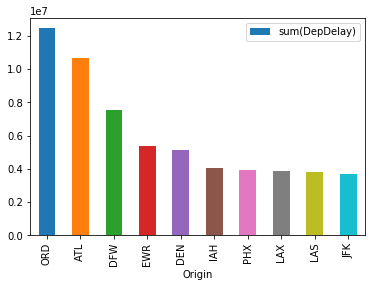

In [6]:
q1delays.head(10).plot.bar(x='Origin', y = 'sum(DepDelay)')

In [7]:
#Destination Arrival Delays
q1arriv = hw_3_df.groupby('Dest').agg(sum('ArrDelay')).orderBy(sum('ArrDelay'), ascending=False).toPandas()
q1arriv.head(10)

,Dest,sum(ArrDelay)
0,ORD,11078714.0
1,ATL,7976196.0
2,EWR,6153557.0
3,DFW,5432036.0
4,LGA,3970472.0
5,JFK,3821193.0
6,SFO,3567379.0
7,DEN,3496720.0
8,LAX,3148780.0
9,IAH,2620319.0


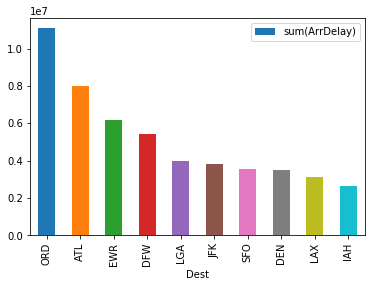

In [8]:
q1arriv.head(10).plot.bar(x='Dest', y = 'sum(ArrDelay)')

In [9]:
#2. Which locations had fewest delays.
hw_3_df_cond = hw_3_df.\
withColumn("ArrDelay_Bin", when(col("ArrDelay") > 0, 1).otherwise(0)).\
withColumn("DepDelay_Bin", when(col("DepDelay") > 0, 1).otherwise(0))

#Origin Departure Delays = fewest
q2depdelay = hw_3_df_cond.groupby('Origin').agg(sum('DepDelay_Bin')).orderBy(sum('DepDelay_Bin')).toPandas()
q2depdelay.head(10)

,Origin,sum(DepDelay_Bin)
0,GLH,0
1,MKC,1
2,PUB,2
3,ISO,2
4,PIR,7
5,EAU,12
6,INL,40
7,BJI,41
8,WYS,45
9,ITH,45


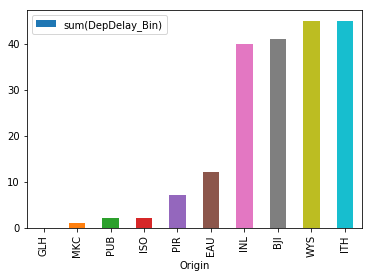

In [10]:
q2depdelay.head(10).plot.bar(x='Origin', y = 'sum(DepDelay_Bin)')

In [11]:
#Destination Arrival Delays = fewest
q2arrdelay = hw_3_df_cond.groupby('Dest').agg(sum('ArrDelay_Bin')).orderBy(sum('ArrDelay_Bin')).toPandas()
q2arrdelay.head(10)

,Dest,sum(ArrDelay_Bin)
0,PVU,0
1,BFF,0
2,OGD,0
3,CYS,0
4,PUB,0
5,MKC,1
6,GLH,2
7,ISO,3
8,PIR,6
9,EAU,20


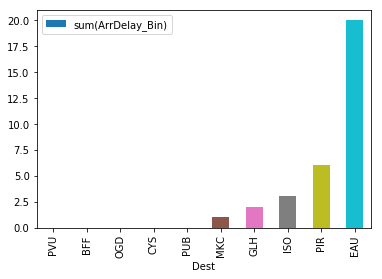

In [12]:
q2arrdelay.head(10).plot.bar(x='Dest', y = 'sum(ArrDelay_Bin)')

In [13]:
#3. Do you see any significant seasonality effects for delays?
#Arrival delays and number of delayed arrival flights
q3arrdelays = hw_3_df_cond.groupby('Year', 'Month').agg(sum('ArrDelay'),sum('ArrDelay_Bin')).orderBy('Year', 'Month').toPandas()
q3arrdelays.head(24)

#As we can see the summer months and winter months result in the greatest number of minutes delayed which makes sense as those are high peak travel periods as well as increased weather issues in the winter.

,Year,Month,sum(ArrDelay),sum(ArrDelay_Bin)
0,2007,1,5539272.0,286334
1,2007,2,7285520.0,284152
2,2007,3,6263303.0,293360
3,2007,4,5129470.0,273055
4,2007,5,4386899.0,275332
5,2007,6,9866891.0,326446
6,2007,7,8928807.0,326559
7,2007,8,8031739.0,317197
8,2007,9,2222395.0,225751
9,2007,10,4045957.0,270098


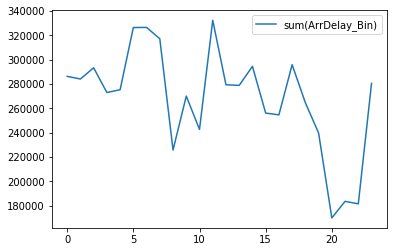

In [14]:
q3arrdelays.plot(y = 'sum(ArrDelay_Bin)')

In [15]:
#Departure delays and number of delayed departure flights
q3depdelays = hw_3_df_cond.groupby('Year', 'Month').agg(sum('DepDelay'),sum('DepDelay_Bin')).orderBy('Year', 'Month').toPandas()
q3depdelays.head(24)

#Similar to the arrival delays, there is clear seasonality effects on numbers of delay and how many minutes each flight is delayed.

,Year,Month,sum(DepDelay),sum(DepDelay_Bin)
0,2007,1,6231524.0,255777
1,2007,2,7574116.0,259288
2,2007,3,7366421.0,276261
3,2007,4,6082001.0,249097
4,2007,5,5203821.0,241699
5,2007,6,9923997.0,307986
6,2007,7,9400459.0,307864
7,2007,8,8663460.0,298530
8,2007,9,3655695.0,195615
9,2007,10,4964959.0,231129


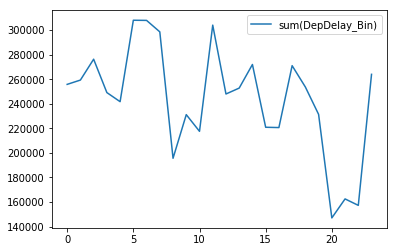

In [16]:
q3depdelays.plot(y = 'sum(DepDelay_Bin)')

In [17]:
#4. Do you see any increase or decrease in delays on weekends?
#Arrival delays by day of week
q4arrdelay = hw_3_df_cond.groupby('DayOfWeek').agg(sum('ArrDelay'),sum('ArrDelay_Bin')).orderBy('DayOfWeek').toPandas()
q4arrdelay
#While most days remain around average, there is a significant increase in minutes of delay and numbers of delays on Thursdays and Fridays potentially due to increased number of flights.  Saturdays has the best performance in terms of lowest number of delays and minutes delayed.

,DayOfWeek,sum(ArrDelay),sum(ArrDelay_Bin)
0,1,19757483.0,964750
1,2,16205829.0,886269
2,3,17192095.0,919485
3,4,22083811.0,996893
4,5,25094580.0,1043106
5,6,10226247.0,718016
6,7,19585982.0,904440


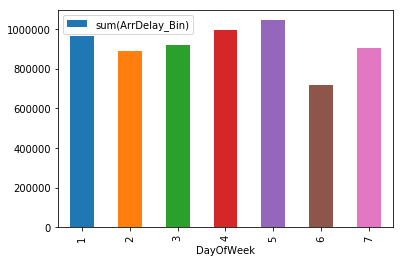

In [18]:
q4arrdelay.plot.bar(x='DayOfWeek', y = 'sum(ArrDelay_Bin)')

In [19]:
#Departure delays by day of week
q4depdelay = hw_3_df_cond.groupby('DayOfWeek').agg(sum('DepDelay'),sum('DepDelay_Bin')).orderBy('DayOfWeek').toPandas()
q4depdelay
#Similar to arrival delays, there is a large increase in delays on Fridays with Thursdays and Mondays being a close second.  Saturday results in the lowest number of delays.

,DayOfWeek,sum(DepDelay),sum(DepDelay_Bin)
0,1,23397552.0,890391
1,2,18955235.0,773921
2,3,19807297.0,804680
3,4,23736147.0,885204
4,5,26924948.0,951585
5,6,15548280.0,690116
6,7,23304687.0,849891


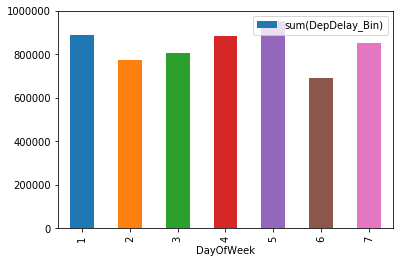

In [20]:
q4depdelay.plot.bar(x='DayOfWeek', y = 'sum(DepDelay_Bin)')

In [21]:
#5. Are flights equally distributed throughout the day?
##Plot the distribution of DepTime, ArrTime (actual departure and arrival time)
%matplotlib inline
import pandas as pd


In [22]:
#assigning two new categories for Arrivals and Departures to figure out what hour of the day the departures and arrivals fall into
hw_3_df_condhr = hw_3_df_cond.\
withColumn("Arrival_Range",\
           when(col("ArrTime") < 100, 0).\
           when((col("ArrTime") >= 100) & (col("ArrTime") < 200), 1).\
           when((col("ArrTime") >= 200) & (col("ArrTime") < 300), 2).\
           when((col("ArrTime") >= 300) & (col("ArrTime") < 400), 3).\
           when((col("ArrTime") >= 400) & (col("ArrTime") < 500), 4).\
           when((col("ArrTime") >= 500) & (col("ArrTime") < 600), 5).\
           when((col("ArrTime") >= 600) & (col("ArrTime") < 700), 6).\
           when((col("ArrTime") >= 700) & (col("ArrTime") < 800), 7).\
           when((col("ArrTime") >= 800) & (col("ArrTime") < 900), 8).\
           when((col("ArrTime") >= 900) & (col("ArrTime") < 1000), 9).\
           when((col("ArrTime") >= 1000) & (col("ArrTime") < 1100), 10).\
           when((col("ArrTime") >= 1100) & (col("ArrTime") < 1200), 11).\
           when((col("ArrTime") >= 1200) & (col("ArrTime") < 1300), 12).\
           when((col("ArrTime") >= 1300) & (col("ArrTime") < 1400), 13).\
           when((col("ArrTime") >= 1400) & (col("ArrTime") < 1500), 14).\
           when((col("ArrTime") >= 1500) & (col("ArrTime") < 1600), 15).\
           when((col("ArrTime") >= 1600) & (col("ArrTime") < 1700), 16).\
           when((col("ArrTime") >= 1700) & (col("ArrTime") < 1800), 17).\
           when((col("ArrTime") >= 1800) & (col("ArrTime") < 1900), 18).\
           when((col("ArrTime") >= 1900) & (col("ArrTime") < 2000), 19).\
           when((col("ArrTime") >= 2000) & (col("ArrTime") < 2100), 20).\
           when((col("ArrTime") >= 2100) & (col("ArrTime") < 2200), 21).\
           when((col("ArrTime") >= 2200) & (col("ArrTime") < 2300), 22).\
           otherwise(23)).\
withColumn("Departure_Range",\
           when(col("DepTime") < 100, 0).\
           when((col("DepTime") >= 100) & (col("DepTime") < 200), 1).\
           when((col("DepTime") >= 200) & (col("DepTime") < 300), 2).\
           when((col("DepTime") >= 300) & (col("DepTime") < 400), 3).\
           when((col("DepTime") >= 400) & (col("DepTime") < 500), 4).\
           when((col("DepTime") >= 500) & (col("DepTime") < 600), 5).\
           when((col("DepTime") >= 600) & (col("DepTime") < 700), 6).\
           when((col("DepTime") >= 700) & (col("DepTime") < 800), 7).\
           when((col("DepTime") >= 800) & (col("DepTime") < 900), 8).\
           when((col("DepTime") >= 900) & (col("DepTime") < 1000), 9).\
           when((col("DepTime") >= 1000) & (col("DepTime") < 1100), 10).\
           when((col("DepTime") >= 1100) & (col("DepTime") < 1200), 11).\
           when((col("DepTime") >= 1200) & (col("DepTime") < 1300), 12).\
           when((col("DepTime") >= 1300) & (col("DepTime") < 1400), 13).\
           when((col("DepTime") >= 1400) & (col("DepTime") < 1500), 14).\
           when((col("DepTime") >= 1500) & (col("DepTime") < 1600), 15).\
           when((col("DepTime") >= 1600) & (col("DepTime") < 1700), 16).\
           when((col("DepTime") >= 1700) & (col("DepTime") < 1800), 17).\
           when((col("DepTime") >= 1800) & (col("DepTime") < 1900), 18).\
           when((col("DepTime") >= 1900) & (col("DepTime") < 2000), 19).\
           when((col("DepTime") >= 2000) & (col("DepTime") < 2100), 20).\
           when((col("DepTime") >= 2100) & (col("DepTime") < 2200), 21).\
           when((col("DepTime") >= 2200) & (col("DepTime") < 2300), 22).\
           otherwise(23))

In [23]:
#Creating a table in order to transfer the subset into a pandas dataframe
hw_3_df_condhr.createOrReplaceTempView("hw_3")
sqlContext.tables().filter("tableName LIKE '%hw_3%'").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |     hw_3|       true|
+--------+---------+-----------+



In [24]:
#converting to pandas
hw_3_arr_df = spark.sql("select Arrival_Range, count(Arrival_Range) as Arrival_Flights from hw_3 group by Arrival_Range order by Arrival_Range" ).toPandas()
hw_3_arr_df.head(30)

,Arrival_Range,Arrival_Flights
0,0,191245
1,1,62934
2,2,20525
3,3,8095
4,4,16776
5,5,71083
6,6,151880
7,7,495014
8,8,695064
9,9,812078


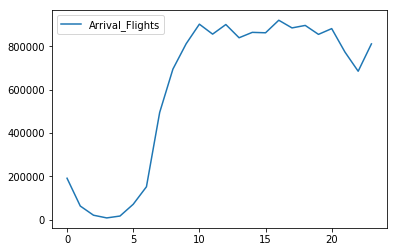

In [25]:
#The arrival flights are relatively evenly distributed from about 8AM until about 8PM
hw_3_arr_df.plot(y = 'Arrival_Flights')

In [26]:
hw_3_dep_df = spark.sql("select Departure_Range, count(Departure_Range) as Departure_Flights from hw_3 group by Departure_Range order by Departure_Range" ).toPandas()
hw_3_dep_df.head(30)

,Departure_Range,Departure_Flights
0,0,44903
1,1,12655
2,2,4150
3,3,1525
4,4,6665
5,5,281852
6,6,919735
7,7,901468
8,8,926572
9,9,894063


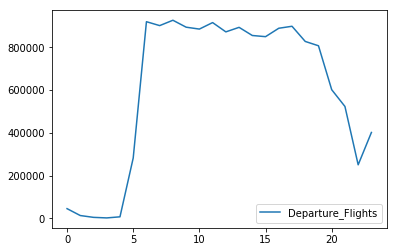

In [27]:
#Similar to arrivals, departures are evenly distributed for a certain period.  This period is from about 6AM until 7PM but then drops off before and after

hw_3_dep_df.plot(y = 'Departure_Flights')

In [28]:
#6. Do you see the worst delays at any certain times of the day?
##Contrast DepTime, ArrTime with CRSDepTime, CRSArrTime (scheduled arrival and departure time; CRS is the Computer Reservation System)

#hw_3_df_condhr.groupby('CRSArrTime','ArrTime','ArrDelay','Arrival_Range').agg(count('*')).show(7)


hw_3_df_feat = hw_3_df_condhr.\
withColumn("Arrival_Diff", hw_3_df_condhr.ArrTime-hw_3_df_condhr.CRSArrTime).\
withColumn("Departure_Diff", hw_3_df_condhr.DepTime-hw_3_df_condhr.CRSDepTime)

hw_3_df_feat2 = hw_3_df_feat.\
withColumn("Arrival_Comparison",\
           when(col("Arrival_Diff") > 0, 1).\
           otherwise(0)).\
withColumn("Departure_Comparison",\
           when(col("Departure_Diff") > 0, 1).\
           otherwise(0))

q6arrivalcomp = hw_3_df_feat2.groupby('Arrival_Range').agg(sum('Arrival_Comparison')).orderBy('Arrival_Range').toPandas()
q6arrivalcomp

#The worst delays appear to be at the end of the day which makes sense as when delays start to happen, they tend to push everything back so the later flights would likely be the most impacted

,Arrival_Range,sum(Arrival_Comparison)
0,0,30602
1,1,21660
2,2,7204
3,3,3121
4,4,2749
5,5,20001
6,6,43506
7,7,123737
8,8,226781
9,9,283208


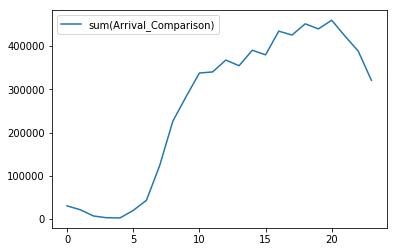

In [29]:
q6arrivalcomp.plot(y = 'sum(Arrival_Comparison)')

In [30]:
q6arrivalcomp = hw_3_df_feat2.groupby('Departure_Range').agg(sum('Departure_Comparison')).orderBy('Departure_Range').toPandas()
q6arrivalcomp

#While arrivals saw the worst performance at 11PM, 7PM to 8PM for departures has the greatest delays which is likely due to similar circumstances to arrivals.

,Departure_Range,sum(Departure_Comparison)
0,0,3971
1,1,3815
2,2,1186
3,3,427
4,4,395
5,5,12016
6,6,176045
7,7,218945
8,8,261992
9,9,299594


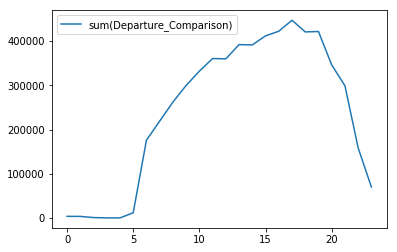

In [31]:
q6arrivalcomp.plot(y = 'sum(Departure_Comparison)')